Boucle globale de lecture de vidéo


state= 0
    img_calibration
    obstacle detection
    start and goal
    global_nav
    
state = 1
    img_calibration
    detect Thymio
    astolfi ou local nav
    
    

In [1]:
#lancer la communication asynchrone avec thymio
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

#vérifier d'avoir installer pyserial

Node eb16048f-962c-44b2-9651-cc3b67bca83b

# Initialisation

In [1]:
#check each import if it's really necessary
import cv2 
import time
import numpy as np
from PIL import Image 
import math
import matplotlib
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

#import from global control
#import from glocal + control
import pyvisgraph as vg
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Polygon, Point, LineString
import time

In [2]:
import Vision as vis
import Global as glob
import control as ctrl
import local_nav as local

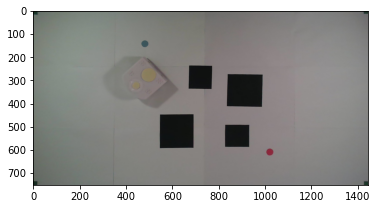

In [10]:
#pour le test utilise une image mais en vrai relier à la caméra et temps réel

#img_final = np.array(Image.open('env_final.jpeg'))
img_final = cv2.imread('env_final.jpeg')
img_final= cv2.flip(img_final, 0)
img_final2 = cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB)
img=vis.img_calibration(img_final2)
#cv2.imwrite('warpped.png', zzz)
plt.figure()
plt.imshow(img)
plt.show()

In [11]:
#obstacle detection
polygons=vis.obstacle_detection(img)
#Start and goal detection
start=vis.detectCircle(img,'start')
goal=vis.detectCircle(img,'goal')

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 43.49it/s]



 Visibility graph input:  [[Point(827.80, 208.20), Point(827.80, 112.80), Point(933.20, 112.80), Point(931.20, 209.20)], [Point(547.80, 253.20), Point(546.80, 106.80), Point(693.20, 109.80), Point(691.20, 254.20)], [Point(837.80, 425.20), Point(835.80, 286.80), Point(988.20, 285.80), Point(990.20, 424.20)], [Point(672.81, 463.20), Point(669.79, 363.81), Point(770.19, 360.79), Point(773.21, 461.20)]] 

Shortest path distance: 727.2782784532847 

0    POLYGON ((827.800 491.802, 827.800 587.200, 93...
1    POLYGON ((547.801 446.801, 546.799 593.204, 69...
2    POLYGON ((837.803 274.799, 835.797 413.199, 98...
3    POLYGON ((672.806 236.796, 669.794 336.194, 77...
0                              POINT (482.373 144.519)
1                              POINT (547.801 253.199)
2                              POINT (770.194 360.794)
3                             POINT (1021.224 609.500)
dtype: geometry 

path  0     POINT (482.373 144.519)
1     POINT (547.801 253.199)
2     POINT (770.194 360.7

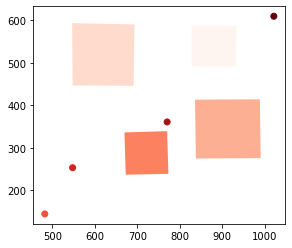

In [12]:
#plot the visibility graph

#a voir si on le met dedans
margin = 0.2
path=glob.global_pathplanning(start,goal,polygons,margin)


# Control and navigation loop

In [4]:
#cap=cv2.VideoCapture(0)

frame 0
frame 1
frame 2
frame 3
frame 4


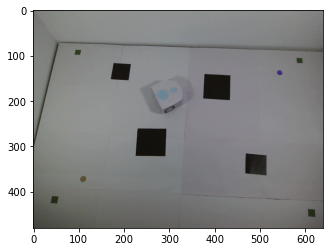

In [11]:
cap=cv2.VideoCapture(1,cv2.CAP_DSHOW)

for i in range (5):
    _, frame = cap.read()
    time.sleep(1)
    print("frame {}".format(i))

cap.release()
    
#frame=vis.img_calibration(frame)
    
plt.figure()
plt.imshow(frame)
plt.show()

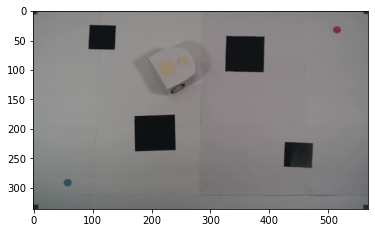

In [4]:
#img_final = cv2.imread(frame)
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
final=vis.img_calibration(img)
plt.figure()
plt.imshow(final)
plt.show()

frame 0
frame 1
frame 2
frame 3
frame 4


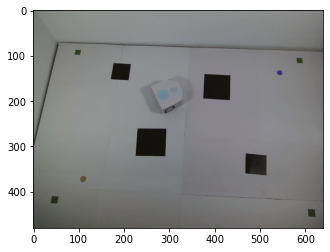

failure in identifying corners
[(46, 418), (98, 93)]


IndexError: list index out of range

In [13]:
cap=cv2.VideoCapture(1,cv2.CAP_DSHOW)
for i in range (5):
    _, frame = cap.read()
    time.sleep(1)
    print("frame {}".format(i))

#cap.release()

plt.figure()
plt.imshow(frame)
plt.show()


time.sleep(5)

while (cap.isOpened()):
    _, frame = cap.read()
    #cap.release()
    #control
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    final=vis.img_calibration(img)
    cv2.imshow("results", final)
    
    if cv2.waitKey(1) & 0xFF ==ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

In [4]:
# Navigation initialisation
checkp=1           # goal checkpoint
actual_angle=0     # angle to xy axis
y = [0,0]          # powers given to motor wheels

# FSM initialisation
state = 0          # States FSM 0=global nav, 1=local nav
obst = [0,0,0]     # measurements from left, middle, right prox sensors
obstThrL = 2500      # low obstacle threshold to switch state 1->0
obstThrL2 = 3000
obstThrH = 4000      # high obstacle threshold to switch state 0->1  

while True:
    
    # get the proximity sensors values and obstacle update
    prox_horizontal = ctrl.read_prox_sensors(node,client)
    obst = [prox_horizontal[0], prox_horizontal[2], prox_horizontal[4]]
    
    # update the state and speed motors values
    state = local.update_state(state,obstThrL,obstThrH, obst)
    y = ctrl.read_motors_speed(node,client)
    
    print("state", state)

    if state == 0:
        
        """
        # With positon estimation when vision and/or kalman ready
        
        actual,angle = getting_vis()
        pred_pos,pred_angle = kalman(actual, angle)
        
        actual_pos=pred_pos
        actual_angle=pred_angle
        
        if actual_pos == checkpoints[checkp]: # other option: if (actual_pos - checkpoints[checkp]) < error
            checkp=checkp+1
        goal_pos=checkpoints[checkp]
        
        y = ctrl.astolfi2(actual_pos, goal_pos, actual_angle, node)
        
        """
        y = [50,50]
        ctrl.set_motors(y[0],y[1],node)

    elif state == 1:
        print("obstacles values", obst)
        y = local.local_nav(prox_horizontal,y)
        print("y ",y)
        ctrl.set_motors(y[0],y[1],node)

ctrl.stopmotors(node)

state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
change state to local
state 1
obstacles values [0, 4828, 4094]
y  [-380, 140]
state 1
obstacles values [0, 4908, 4043]
y  [-340, 100]
state 1
obstacles values [0, 4244, 3912]
y  [-468, 180]
state 1
obstacles values [0, 0, 2652]
y  [-248, 168]
state 1
obstacles values [0, 0, 2652]
y  [-248, 168]
change state to global
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
state 0
c

KeyboardInterrupt: 

In [5]:
ctrl.stopmotors(node)